### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 6


### Дисциплина: Методы машинного обучения

##### Студент:  Миронов Дмитрий Андреевич
##### Группа:   НПИ-02-21

## Москва 2024
***

### Вариант №9


## Индивидуальное задание
1. Набор данных stanford_dogs с изменением разрешения до 60x96
2. Классы с метками 2,4,8,16
3. Требования к архитектуре сети MLP:
Последовательный API с методом add() при создании
Функция потерь: категориальная кросс-энтропия
Кол-во скрытых слоев 6
Кол-во нейронов 120 в первом скрытом слое, уменьшающееся на 10 с каждым последующим скрытым слоем
Использование слоев пакетной нормализации
4. Требования к архитектуре сети CNN:
Функциональный API при создании
Функция потерь: разреженная категориальная кросс-энтропия
Кол-во сверточных слоев 3
Количество фильтров в сверточных слоях 32
Размеры фильтра 3х3
Использование слоев с регуляризацией L1L2
5. Требования к архитектуре сети RNN:
Последовательный API со списком слоев при создании
Функция потерь: категориальная кросс-энтропия
Слой LSTM с 96 нейронами
Использование слоев dropout
6. Показатель качества многоклассовой классификации:
максимальная точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.


Импортируем библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import precision_score



1.	Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.  

In [65]:
# Загрузка набора данных с разбиением на обучающую, валидационную и тестовую выборки
(ds_train, ds_val, ds_test) = tfds.load('stanford_dogs', split=['train[:80%]', 'train[80%:]', 'test'], as_supervised=True)

# Преобразование изображений к разрешению 60x96
IMG_HEIGHT = 60
IMG_WIDTH = 96

def format_image(image, label):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image, label

ds_train = ds_train.map(format_image)
ds_val = ds_val.map(format_image)
ds_test = ds_test.map(format_image)

# Преобразование в DataFrame
def ds_to_dataframe(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

df_train = ds_to_dataframe(ds_train)
df_val = ds_to_dataframe(ds_val)
df_test = ds_to_dataframe(ds_test)

# Проверка формы DataFrame
df_train.shape, df_val.shape, df_test.shape


((9600, 2), (2400, 2), (8580, 2))

2.	Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте несколько изображений.

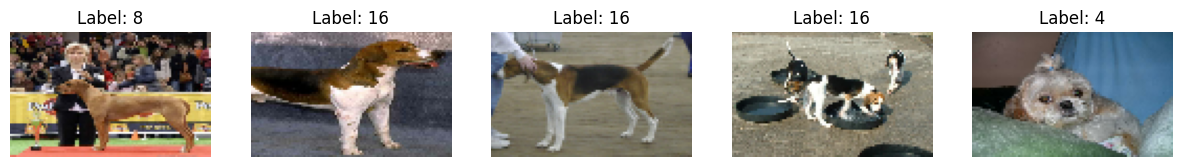

In [66]:
# Фильтрация данных для оставления только нужных классов
TARGET_CLASSES = [2, 4, 8, 16]

def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, TARGET_CLASSES))

ds_train = ds_train.filter(filter_classes)
ds_val = ds_val.filter(filter_classes)
ds_test = ds_test.filter(filter_classes)

# Подсчет количества элементов в каждом наборе данных
num_train = tf.data.experimental.cardinality(ds_train).numpy()
num_val = tf.data.experimental.cardinality(ds_val).numpy()
num_test = tf.data.experimental.cardinality(ds_test).numpy()

# Перемешивание наборов данных
ds_train = ds_train.shuffle(buffer_size=num_train)
ds_val = ds_val.shuffle(buffer_size=num_val)
ds_test = ds_test.shuffle(buffer_size=num_test)

# Визуализация нескольких изображений
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(tfds.as_numpy(dataset.take(num_images))):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.astype('uint8'))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Визуализация изображений из обучающей выборки
visualize_images(ds_train)

3.	Постройте нейронные сети MLP, CNN и RNN для задачи многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании), используя функцию потерь, указанную в индивидуальном задании. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Обучайте нейронные сети с использованием валидационной выборки, сформированной в п. 1. Останавливайте обучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд. Для каждой нейронной сети выведите количество потребовавшихся эпох обучения.  

##MLP

In [67]:
# Преобразование меток в диапазон от 0 до len(TARGET_CLASSES) - 1
label_mapping = {label: idx for idx, label in enumerate(TARGET_CLASSES)}

def map_labels(image, label):
    return image, label_mapping[label.numpy()]

ds_train = ds_train.map(lambda image, label: tf.py_function(func=map_labels, inp=[image, label], Tout=(tf.float32, tf.int32)))
ds_val = ds_val.map(lambda image, label: tf.py_function(func=map_labels, inp=[image, label], Tout=(tf.float32, tf.int32)))
ds_test = ds_test.map(lambda image, label: tf.py_function(func=map_labels, inp=[image, label], Tout=(tf.float32, tf.int32)))

# Подготовка данных для MLP
def prepare_dataset(ds, num_classes):
    images = []
    labels = []
    for image, label in tfds.as_numpy(ds):
        images.append(image.flatten())
        labels.append(tf.keras.utils.to_categorical(label, num_classes=num_classes))
    return np.array(images), np.array(labels)

num_classes = len(TARGET_CLASSES)
x_train, y_train = prepare_dataset(ds_train, num_classes)
x_val, y_val = prepare_dataset(ds_val, num_classes)

# Создание модели MLP
mlp_model = Sequential()
mlp_model.add(Dense(120, activation='relu', input_shape=(IMG_HEIGHT * IMG_WIDTH * 3,)))
mlp_model.add(BatchNormalization())

# Добавление 6 скрытых слоев с уменьшением нейронов на 10 в каждом последующем слое
for neurons in range(120, 60, -10):
    mlp_model.add(Dense(neurons, activation='relu'))
    mlp_model.add(BatchNormalization())

mlp_model.add(Dense(num_classes, activation='softmax'))

# Компиляция модели
mlp_model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Обучение модели
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_mlp = mlp_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, callbacks=[callback])

print(f"Количество эпох для обучения MLP: {len(history_mlp.history['loss'])}")

Epoch 1/100
3/3 [==============================] - 5s 342ms/step - loss: 1.7322 - accuracy: 0.2827 - val_loss: 17.1167 - val_accuracy: 0.2958
Epoch 2/100
3/3 [==============================] - 0s 95ms/step - loss: 1.3905 - accuracy: 0.4438 - val_loss: 2.3072 - val_accuracy: 0.2958
Epoch 3/100
3/3 [==============================] - 0s 128ms/step - loss: 1.1604 - accuracy: 0.5258 - val_loss: 1.9660 - val_accuracy: 0.2817
Epoch 4/100
3/3 [==============================] - 0s 102ms/step - loss: 0.9286 - accuracy: 0.6079 - val_loss: 1.7809 - val_accuracy: 0.3099
Epoch 5/100
3/3 [==============================] - 0s 121ms/step - loss: 0.7555 - accuracy: 0.7264 - val_loss: 1.5844 - val_accuracy: 0.3099
Epoch 6/100
3/3 [==============================] - 0s 117ms/step - loss: 0.6110 - accuracy: 0.7933 - val_loss: 1.5255 - val_accuracy: 0.2958
Epoch 7/100
3/3 [==============================] - 0s 123ms/step - loss: 0.5465 - accuracy: 0.8328 - val_loss: 1.5658 - val_accuracy: 0.2958
Epoch 8/100
3

## CNN

In [45]:
# Создание модели CNN
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2())(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2())(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2())(x)
x = BatchNormalization()(x)
x = Flatten()(x)
outputs = Dense(num_classes, activation='softmax')(x)

cnn_model = Model(inputs, outputs)

# Компиляция модели
cnn_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Подготовка данных для CNN
def prepare_dataset_cnn(ds):
    images = []
    labels = []
    for image, label in tfds.as_numpy(ds):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)


x_train, y_train = prepare_dataset_cnn(ds_train)
x_val, y_val = prepare_dataset_cnn(ds_val)

# Обучение модели
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
history_cnn = cnn_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, callbacks=[callback])

print(f"Количество эпох для обучения CNN: {len(history_cnn.history['loss'])}")

Epoch 1/100
3/3 [==============================] - 13s 4s/step - loss: 14.5467 - accuracy: 0.3495 - val_loss: 32.9254 - val_accuracy: 0.3239
Epoch 2/100
3/3 [==============================] - 10s 3s/step - loss: 11.5120 - accuracy: 0.8754 - val_loss: 30.3461 - val_accuracy: 0.2676
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 10.8013 - accuracy: 0.9483 - val_loss: 39.8131 - val_accuracy: 0.2254
Epoch 4/100
3/3 [==============================] - 11s 3s/step - loss: 10.3813 - accuracy: 0.9848 - val_loss: 37.7830 - val_accuracy: 0.2254
Epoch 5/100
3/3 [==============================] - 11s 4s/step - loss: 10.1987 - accuracy: 0.9970 - val_loss: 27.4644 - val_accuracy: 0.2676
Epoch 6/100
3/3 [==============================] - 9s 3s/step - loss: 10.0408 - accuracy: 0.9970 - val_loss: 20.0887 - val_accuracy: 0.3239
Epoch 7/100
3/3 [==============================] - 11s 3s/step - loss: 9.8580 - accuracy: 1.0000 - val_loss: 16.7978 - val_accuracy: 0.3521
Epoch 8/100
3/3 

## RNN

In [6]:
# Подготовка данных для RNN
def prepare_dataset_rnn(ds, num_classes):
    images = []
    labels = []
    for image, label in tfds.as_numpy(ds):
        images.append(image)
        labels.append(tf.keras.utils.to_categorical(label, num_classes=num_classes))
    return np.array(images), np.array(labels)

num_classes = len(TARGET_CLASSES)
x_train1, y_train1 = prepare_dataset_rnn(ds_train, num_classes)
x_val1, y_val1 = prepare_dataset_rnn(ds_val, num_classes)

# Преобразуем изображения в последовательность строк
x_train1 = x_train1.reshape((x_train1.shape[0], IMG_HEIGHT, IMG_WIDTH * 3))
x_val1 = x_val1.reshape((x_val1.shape[0], IMG_HEIGHT, IMG_WIDTH * 3))

# Создание модели RNN
rnn_model = Sequential([
    LSTM(96, input_shape=(IMG_HEIGHT, IMG_WIDTH * 3)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Компиляция модели
rnn_model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Обучение модели
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_rnn = rnn_model.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=100, batch_size=128, callbacks=[callback])

print(f"Количество эпох для обучения RNN: {len(history_rnn.history['loss'])}")

Epoch 1/100
3/3 [==============================] - 3s 457ms/step - loss: 1.6013 - accuracy: 0.1945 - val_loss: 1.3990 - val_accuracy: 0.3239
Epoch 2/100
3/3 [==============================] - 0s 167ms/step - loss: 1.4934 - accuracy: 0.2340 - val_loss: 1.4407 - val_accuracy: 0.3380
Epoch 3/100
3/3 [==============================] - 1s 180ms/step - loss: 1.4525 - accuracy: 0.2736 - val_loss: 1.3839 - val_accuracy: 0.3521
Epoch 4/100
3/3 [==============================] - 0s 165ms/step - loss: 1.4451 - accuracy: 0.2523 - val_loss: 1.3973 - val_accuracy: 0.2535
Epoch 5/100
3/3 [==============================] - 0s 174ms/step - loss: 1.4222 - accuracy: 0.3222 - val_loss: 1.4102 - val_accuracy: 0.2676
Epoch 6/100
3/3 [==============================] - 0s 165ms/step - loss: 1.4214 - accuracy: 0.2888 - val_loss: 1.3988 - val_accuracy: 0.2817
Epoch 7/100
3/3 [==============================] - 0s 167ms/step - loss: 1.4155 - accuracy: 0.3222 - val_loss: 1.3774 - val_accuracy: 0.2958
Epoch 8/100
3

4.	Оцените качество многоклассовой классификации нейронными сетями MLP, CNN и RNN на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите архитектуру нейронной сети с лучшим качеством.  

In [68]:
# Подготовка данных для MLP
x_test_mlp, y_test_mlp = prepare_dataset(ds_test, num_classes)

# Подготовка данных для CNN
x_test_cnn, y_test_cnn = prepare_dataset_cnn(ds_test)

# Подготовка данных для RNN
x_test_rnn, y_test_rnn = prepare_dataset_rnn(ds_test, num_classes)
x_test_rnn = x_test_rnn.reshape((x_test_rnn.shape[0], IMG_HEIGHT, IMG_WIDTH * 3))

# Оценка моделей на тестовой выборке
# MLP
y_pred_mlp = np.argmax(mlp_model.predict(x_test_mlp), axis=1)
y_test_mlp = np.argmax(y_test_mlp, axis=1)
precision_mlp = precision_score(y_test_mlp, y_pred_mlp, average='macro')

# CNN
y_pred_cnn = np.argmax(cnn_model.predict(x_test_cnn), axis=1)
precision_cnn = precision_score(y_test_cnn, y_pred_cnn, average='macro')

# RNN
y_pred_rnn = np.argmax(rnn_model.predict(x_test_rnn), axis=1)
y_test_rnn = np.argmax(y_test_rnn, axis=1)
precision_rnn = precision_score(y_test_rnn, y_pred_rnn, average='macro')

# Вывод показателей точности
print(f"MLP Precision: {precision_mlp}")
print(f"CNN Precision: {precision_cnn}")
print(f"RNN Precision: {precision_rnn}")

# Определение и вывод лучшей модели
if precision_mlp >= precision_cnn and precision_mlp >= precision_rnn:
    best_model = 'MLP'
    best_model_precision = precision_mlp
    best_model_architecture = mlp_model.summary()
elif precision_cnn >= precision_mlp and precision_cnn >= precision_rnn:
    best_model = 'CNN'
    best_model_precision = precision_cnn
    best_model_architecture = cnn_model.summary()
else:
    best_model = 'RNN'
    best_model_precision = precision_rnn
    best_model_architecture = rnn_model.summary()

print(f"Лучший показатель точности классов (precision): {best_model_precision}")
print(f"Архитектура лучшей модели ({best_model})")

13/13 [==============================] - 2s 160ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13/13 [==============================] - 1s 53ms/step
MLP Precision: 0.4083448405052451
CNN Precision: 0.4420191540303272
RNN Precision: 0.30594047781686534
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 96, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 58, 94, 32)        896       
                                                                 
 batch_normalization_67 (Ba  (None, 58, 94, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 92, 32)        9248      
                                                                 
 batch_normalization_68 (Ba  (None, 56, 92, 32)        128       
 tchNormalization)                

5.	Визуализируйте кривые обучения трех построенных моделей для показателя потерь на валидационной выборке на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).

In [69]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

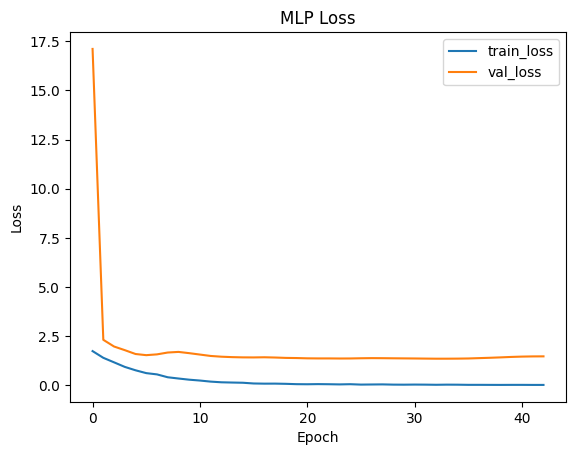

In [70]:
plot_loss(history_mlp, "MLP Loss")

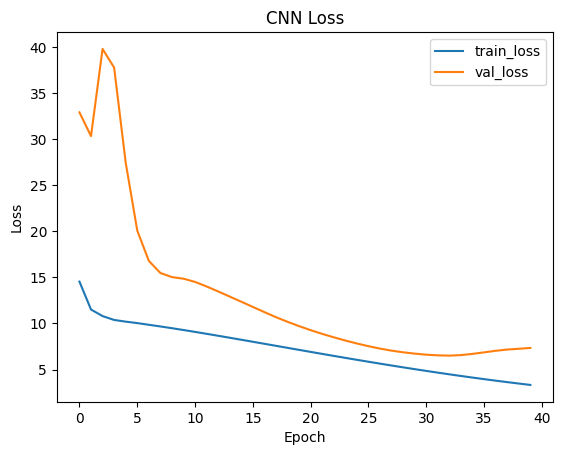

In [49]:
plot_loss(history_cnn, "CNN Loss")

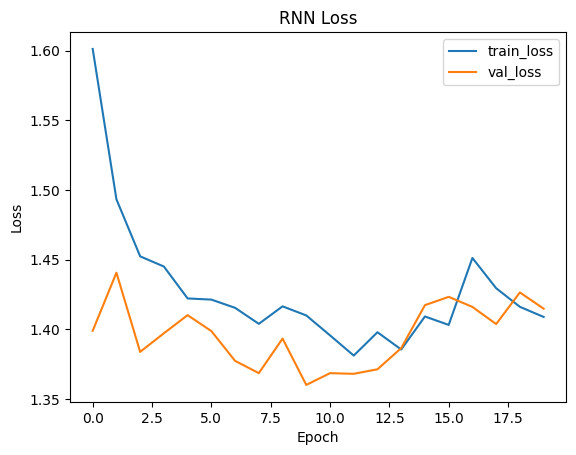

In [16]:
plot_loss(history_rnn, "RNN Loss")

6.	Визуализируйте кривые обучения трех построенных моделей для показателя доли верных ответов на валидационной выборке на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

In [71]:
def epochs(history):
  return range(1, len(history.history['val_loss']) + 1)

In [72]:
epochs_mlp = epochs(history_mlp)
epochs_cnn = epochs(history_cnn)
epochs_rnn = epochs(history_rnn)

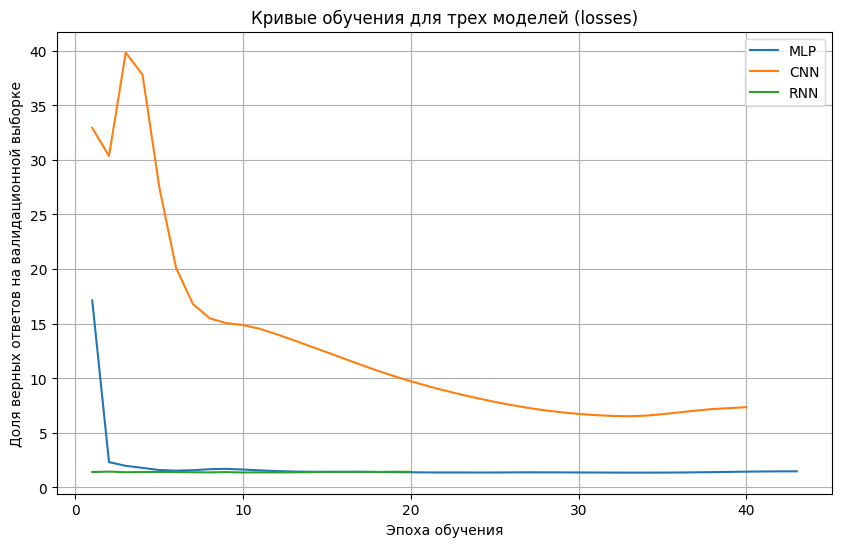

In [73]:
plt.figure(figsize=(10, 6))

plt.plot(epochs_mlp, history_mlp.history['val_loss'], label='MLP')
plt.plot(epochs_cnn, history_cnn.history['val_loss'], label='CNN')
plt.plot(epochs_rnn, history_rnn.history['val_loss'], label='RNN')

plt.title('Кривые обучения для трех моделей (losses)')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов на валидационной выборке')
plt.legend()
plt.grid(True)
plt.show()

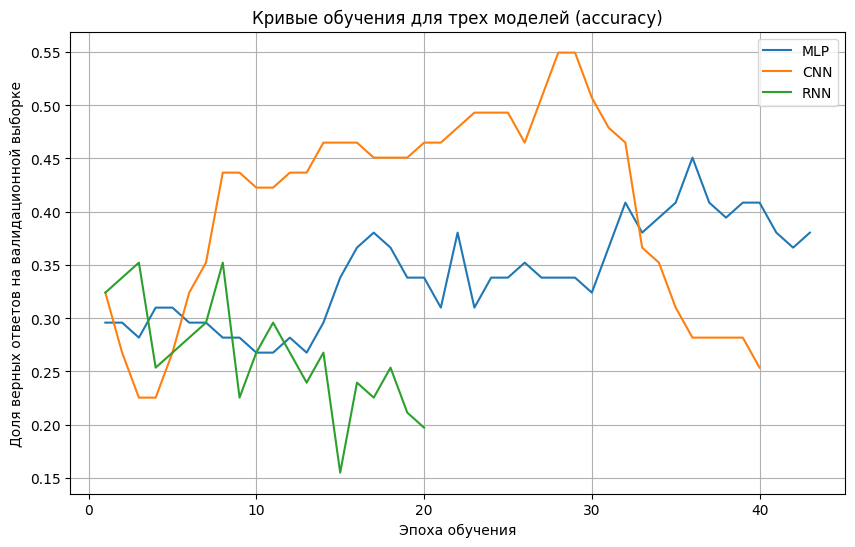

In [74]:
plt.figure(figsize=(10, 6))

plt.plot(epochs_mlp, history_mlp.history['val_accuracy'], label='MLP')
plt.plot(epochs_cnn, history_cnn.history['val_accuracy'], label='CNN')
plt.plot(epochs_rnn, history_rnn.history['val_accuracy'], label='RNN')

plt.title('Кривые обучения для трех моделей (accuracy)')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов на валидационной выборке')
plt.legend()
plt.grid(True)
plt.show()

7.	Используя модель нейронной сети с лучшей долей верных ответов на тестовой выборке, определите для каждого из классов два изображения в тестовой выборке, имеющие минимальную и максимальную вероятности классификации в правильный класс, и визуализируйте эти изображения.

13/13 [==============================] - 2s 165ms/step


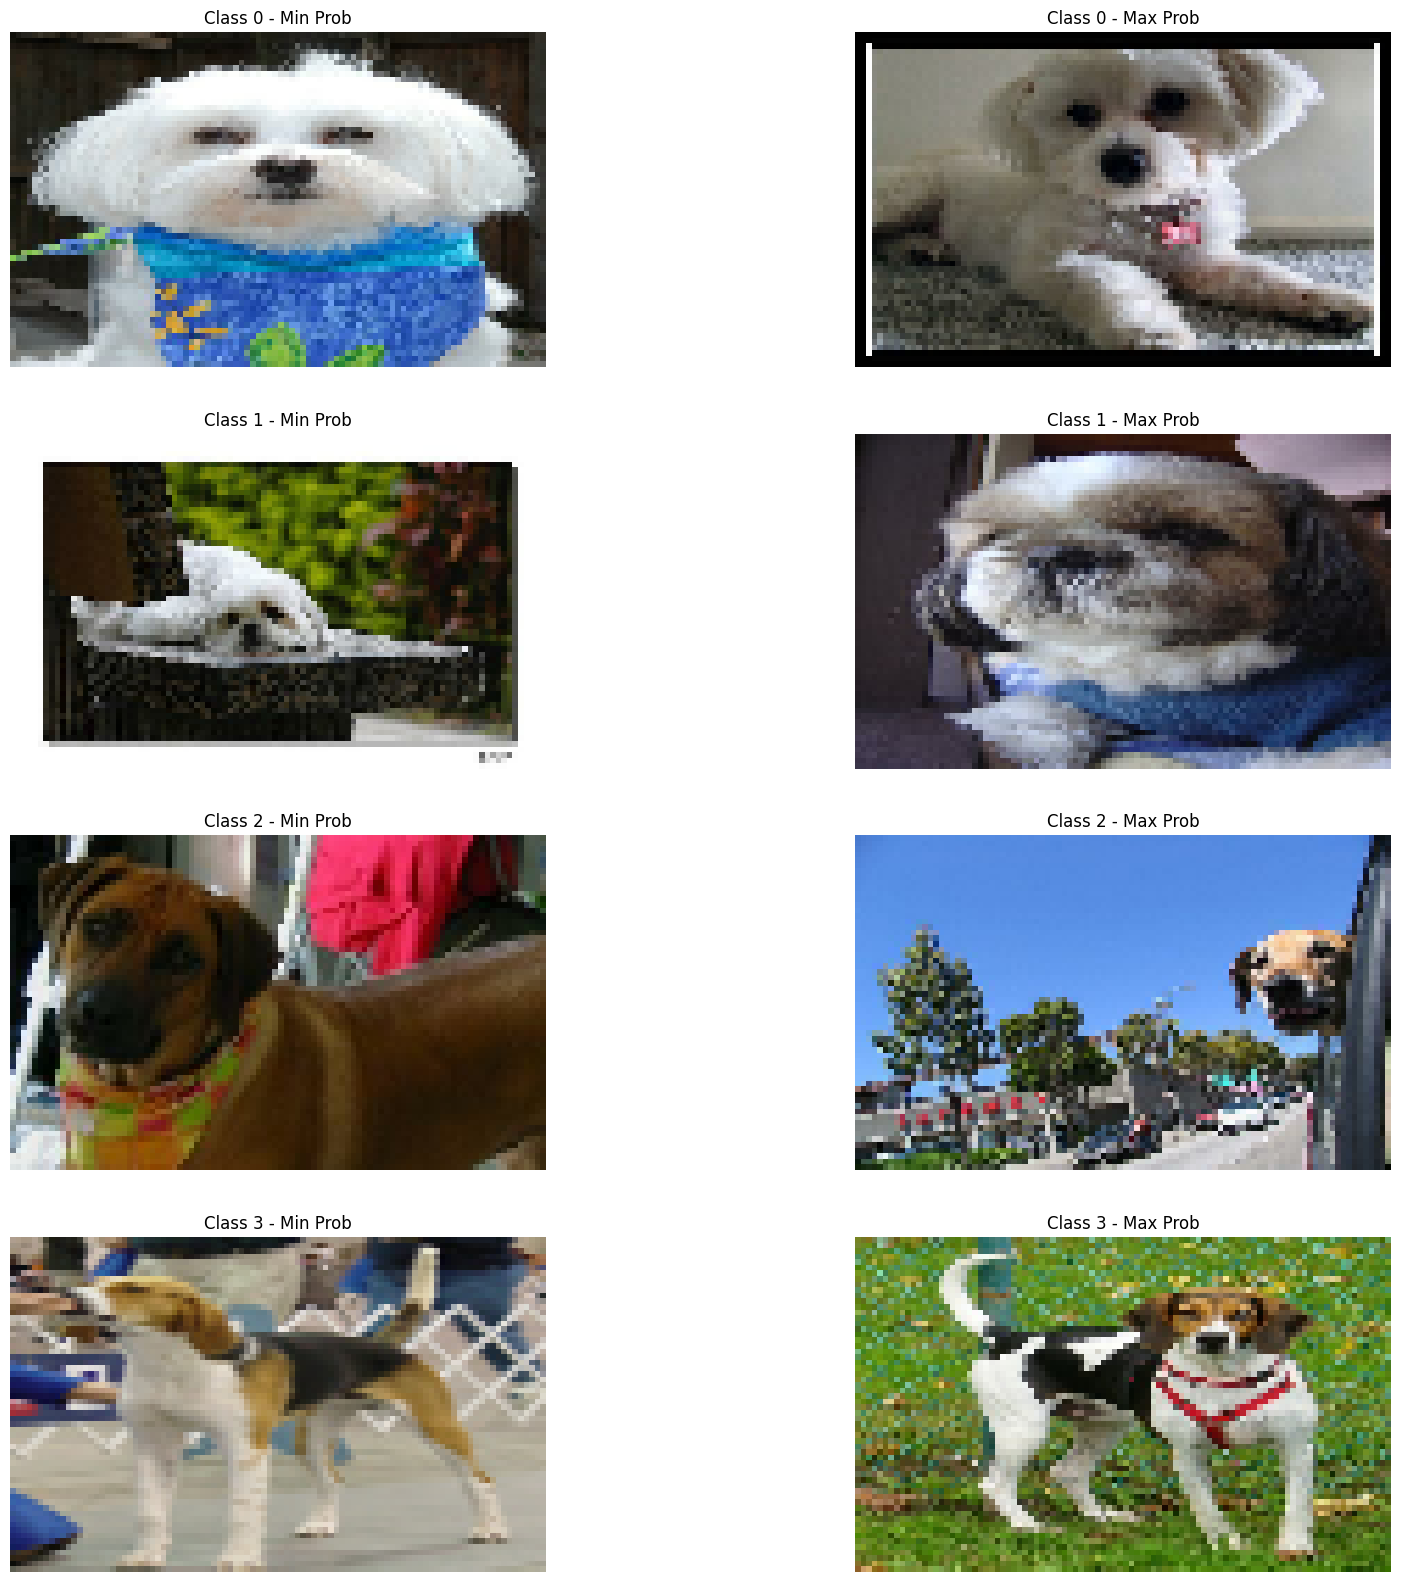

In [75]:

# Подготовка данных для CNN (для тестовой выборки)
x_test, y_test = prepare_dataset_cnn(ds_test)

# Получение предсказаний от модели CNN
y_pred_probs = cnn_model.predict(x_test)

# Определение минимальных и максимальных вероятностей для каждого класса
min_max_images = {}
for class_idx in range(num_classes):
    class_probs = y_pred_probs[:, class_idx]
    class_indices = np.where(y_test == class_idx)[0]

    class_probs_for_indices = class_probs[class_indices]

    min_prob_index = class_indices[np.argmin(class_probs_for_indices)]
    max_prob_index = class_indices[np.argmax(class_probs_for_indices)]

    min_max_images[class_idx] = {
        'min_prob_index': min_prob_index,
        'max_prob_index': max_prob_index
    }

# Визуализация изображений
def visualize_min_max_images(x_data, y_data, min_max_images, num_classes):
    plt.figure(figsize=(20, num_classes * 5))

    for class_idx in range(num_classes):
        min_prob_index = min_max_images[class_idx]['min_prob_index']
        max_prob_index = min_max_images[class_idx]['max_prob_index']

        min_prob_image = x_data[min_prob_index].astype('uint8')
        max_prob_image = x_data[max_prob_index].astype('uint8')

        # Визуализация изображения с минимальной вероятностью
        plt.subplot(num_classes, 2, class_idx * 2 + 1)
        plt.imshow(min_prob_image)
        plt.title(f"Class {class_idx} - Min Prob")
        plt.axis('off')

        # Визуализация изображения с максимальной вероятностью
        plt.subplot(num_classes, 2, class_idx * 2 + 2)
        plt.imshow(max_prob_image)
        plt.title(f"Class {class_idx} - Max Prob")
        plt.axis('off')

    plt.show()

# Визуализация
visualize_min_max_images(x_test, y_test, min_max_images, num_classes)
